## Week 6 Kaggle Project - House Prices - Advanced Regression Techniques

This week I will attempt a regression problem using a deep neural network instead of a more basic regression.

The project comes from the below:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

The goal is to predict the price of a house given a very wide range of characteristics. When conducting traditional regression analysis with many variables, it is very difficult to avoid overfitting, I will explore if applying a neural network can improve on this.

One advantages of a traditional regression analysis is that it is an easy to understand model, while a neural network can feel like a black box.

My submissions is available in the below git repository:



First job is to mount my google drive and load my libraries

In [34]:
# !pip install scikeras tensorflow scikit-learn --upgrade

In [35]:
from sklearn.base import RegressorMixin
import warnings

import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import skew
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratory Data Analysis

The variables that will be used to predict the house prices are all described in a text file that comes with this project. Some of them include:

*   Slope of Property
*   Material and Finish of the House
*   Height of Basement


-

There are many categorical variables in this problem as well as numerical like sq footage of property.


In [37]:
BASE_DIR = "/content/drive/MyDrive/HousePrices"

TrainPath = os.path.join(BASE_DIR, "train.csv")
train_df = pd.read_csv(TrainPath)

TestPath = os.path.join(BASE_DIR, "test.csv")
test_df = pd.read_csv(TestPath)

In [38]:
print("Dataset shape:", train_df.shape)
print(train_df.head())

print("Test shape:", test_df.shape)

Dataset shape: (1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePri

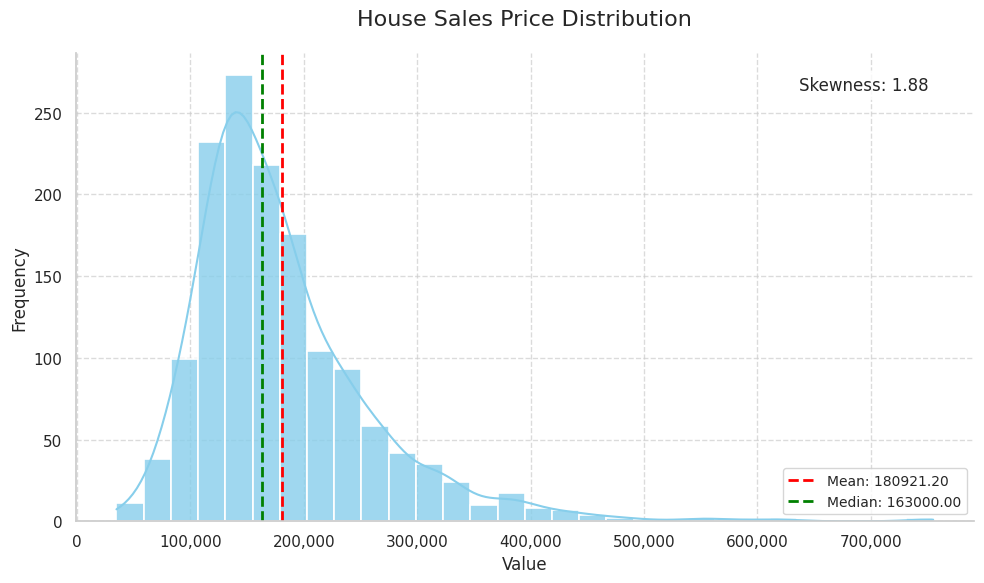

In [39]:

# Set style for better aesthetics
sns.set(style="whitegrid", palette="pastel")

# Calculate basic statistics
mean_val = np.mean(train_df['SalePrice'])
median_val = np.median(train_df['SalePrice'])
skewness = skew(train_df['SalePrice'])

# Create figure
plt.figure(figsize=(10, 6))

# Create histogram with density curve
ax = sns.histplot(train_df['SalePrice'], bins=30, kde=True,
                 edgecolor='white', linewidth=1.2,
                 color='skyblue', alpha=0.8)

# Add title and labels
plt.title('House Sales Price Distribution', fontsize=16, pad=20)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add mean and median lines
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')

# Add skewness annotation
plt.annotate(f'Skewness: {skewness:.2f}',
             xy=(0.95, 0.95), xycoords='axes fraction',
             ha='right', va='top', fontsize=12,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Customize grid and spines
ax.grid(True, linestyle='--', alpha=0.7)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Add legend
plt.legend(fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

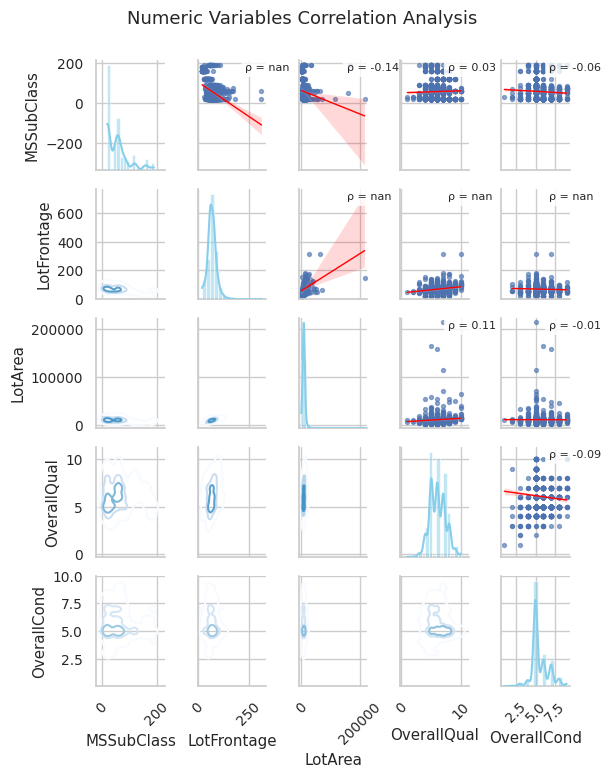

In [60]:
sns.set(style="whitegrid", font_scale=0.9)  # Reduced from 1.1 to 0.9

# Select numeric columns
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()[1:6]

# Create PairGrid with smaller dimensions
g = sns.PairGrid(train_df[num_cols], diag_sharey=False, height=1.5, aspect=0.8)  # Reduced height
g.fig.suptitle('Numeric Variables Correlation Analysis', y=1.02)

# Upper triangle - smaller scatter points
g.map_upper(sns.regplot, scatter_kws={'s': 8, 'alpha': 0.6},  # Reduced point size
            line_kws={'color': 'red', 'lw': 1.0})  # Thinner line

# Diagonal - smaller histograms
g.map_diag(sns.histplot, kde=True, color='skyblue', edgecolor='white', bins=15)

# Lower triangle - kernel density estimates
g.map_lower(sns.kdeplot, cmap='Blues', levels=4)  # Fewer levels

# Add correlation coefficients with smaller font
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    x = num_cols[i]
    y = num_cols[j]
    corr = stats.pearsonr(train_df[num_cols][x], train_df[num_cols][y])[0]
    g.axes[i,j].annotate(f"ρ = {corr:.2f}", xy=(.7, .9),
                        xycoords=g.axes[i,j].transAxes,
                        fontsize=8,  # Smaller font
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Rotate x-axis labels for better fit
for ax in g.axes[-1,:]:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout more tightly
plt.tight_layout(pad=0.5)
plt.show()

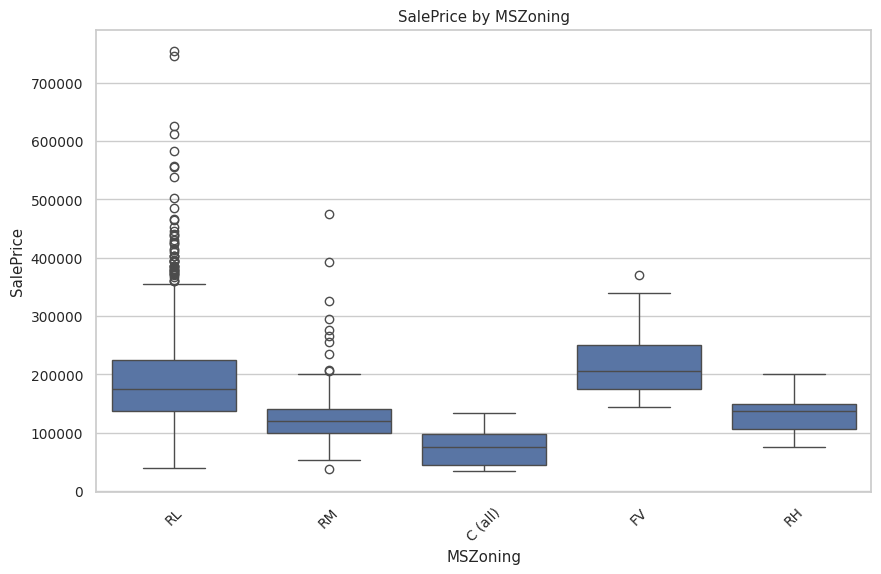

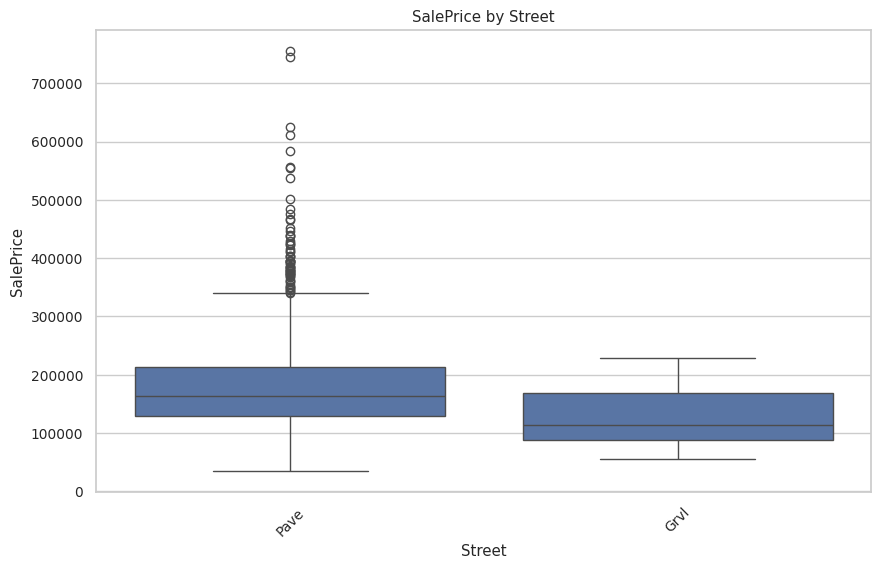

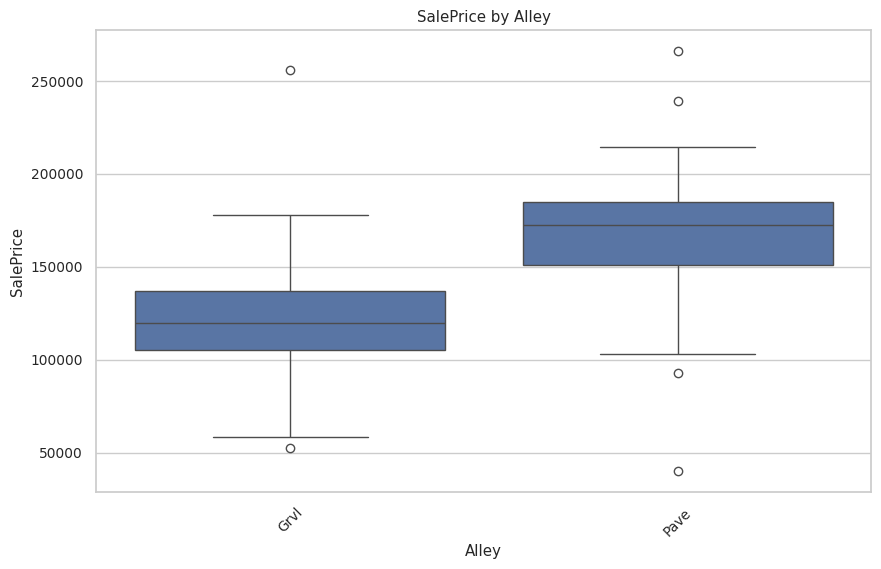

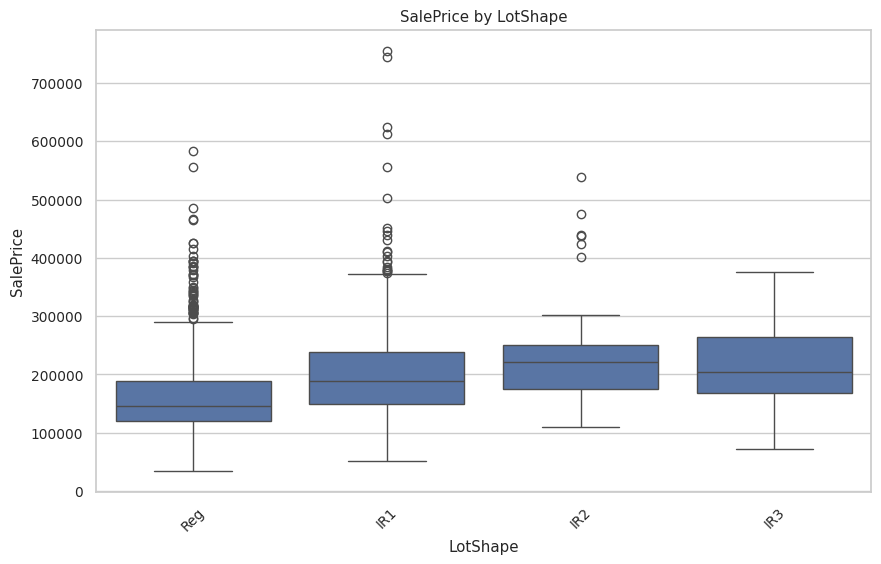

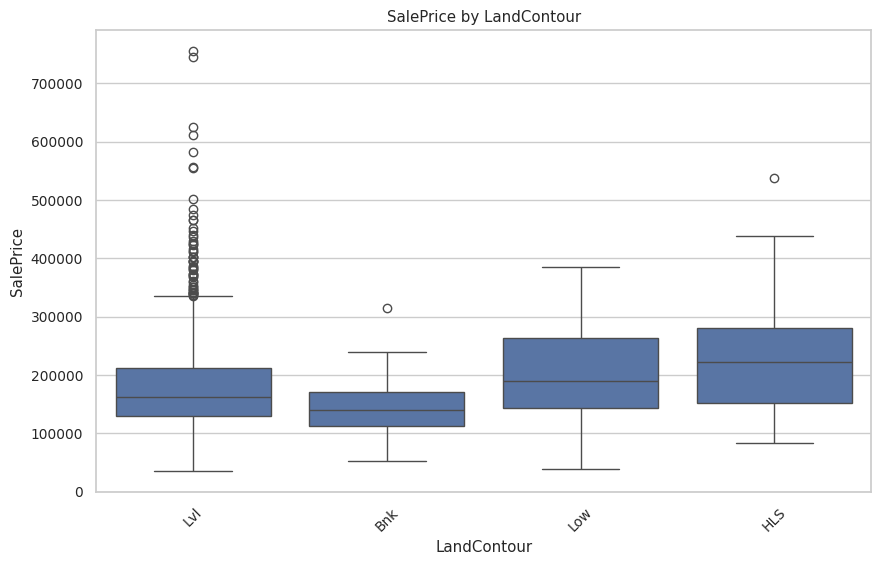

In [41]:
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols[:5]:  # Just first 5 for example
    plt.figure(figsize=(10,6))
    sns.boxplot(x=col, y='SalePrice', data=train_df)
    plt.xticks(rotation=45)
    plt.title(f'SalePrice by {col}')
    plt.show()

We have a skewed price dataset with no houses being sold for less than about 50,000 USD

There are 80 explanatory variables and 1460 observations in the train set with 1459 observations in the test set.



## Model Analysis (building and training)

For my first go at this I am going to include all of the variables and not use any dropout - which should result in a very overfit model.

I will then apply dropouts and a grid search varying the batch size and the dropout rate to try and improve the test results

I will also run a multifactoral linear regression

First I will implement a simple regression model

Top 5 correlated features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']

Mean Squared Error: 1598354833.09
R² Score: 0.7916


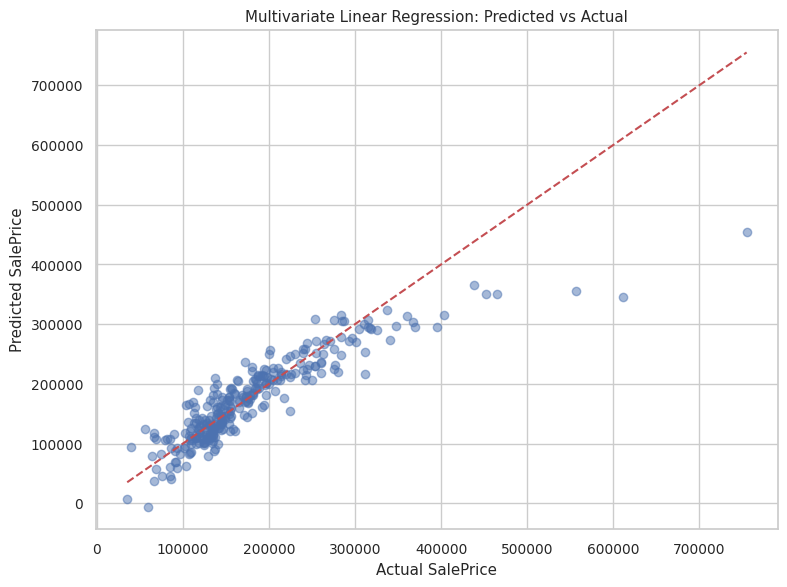

In [42]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Get numeric features
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Step 2: Remove target variable and compute correlations
num_cols.remove('SalePrice')
correlations = train_df[num_cols].corrwith(train_df['SalePrice']).abs()

# Step 3: Select top 5 correlated features
top_5_features = correlations.sort_values(ascending=False).head(5).index.tolist()
print(f"Top 5 correlated features: {top_5_features}")

# Step 4: Prepare data
X = train_df[top_5_features]
y = train_df['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Predict and evaluate
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"\nMean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

# Step 7: Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Multivariate Linear Regression: Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
print(test_df[top_5_features])

      OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF
0               5        896         1.0       730.0        882.0
1               6       1329         1.0       312.0       1329.0
2               5       1629         2.0       482.0        928.0
3               6       1604         2.0       470.0        926.0
4               8       1280         2.0       506.0       1280.0
...           ...        ...         ...         ...          ...
1454            4       1092         0.0         0.0        546.0
1455            4       1092         1.0       286.0        546.0
1456            5       1224         2.0       576.0       1224.0
1457            5        970         0.0         0.0        912.0
1458            7       2000         3.0       650.0        996.0

[1459 rows x 5 columns]


In [44]:

# The best_model is a pipeline that includes the preprocessor, so we can directly use it on the raw test data
testy = test_df[top_5_features].copy()
testy = testy.fillna(testy.mean())

predictions_testmf = model.predict(testy).flatten()

# Create the submission file
submission_mf = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions_testmf
})

submission_mf.to_csv('submission_mf.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!


Below is my first Neural Network model

For Numerical variables I have to standardise them around the median.

For Categorical variables which are non binary and non ordinal I have to create binary variables for each of the possible responses - this is called one hot encoding.

In [45]:
X = train_df.drop(columns=['SalePrice', 'Id'])
y = train_df['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove 'SalePrice' from numerical and categorical columns

num_cols.remove('SalePrice')
num_cols.remove('Id')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

In [47]:
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(input_shape,)),

        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [48]:

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

input_shape = X_train_processed.shape[1]

# Build and compile model
model = build_model(input_shape)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [49]:
history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_val_processed, y_val),  # Use your test set here
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0
)


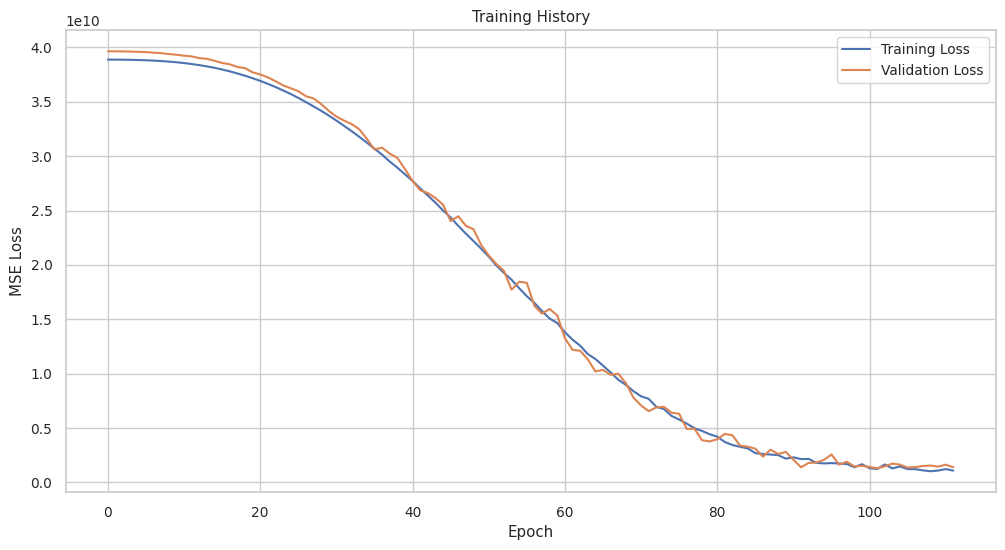


Validation MSE: 1280349952.00
Validation MAE: 24180.64
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


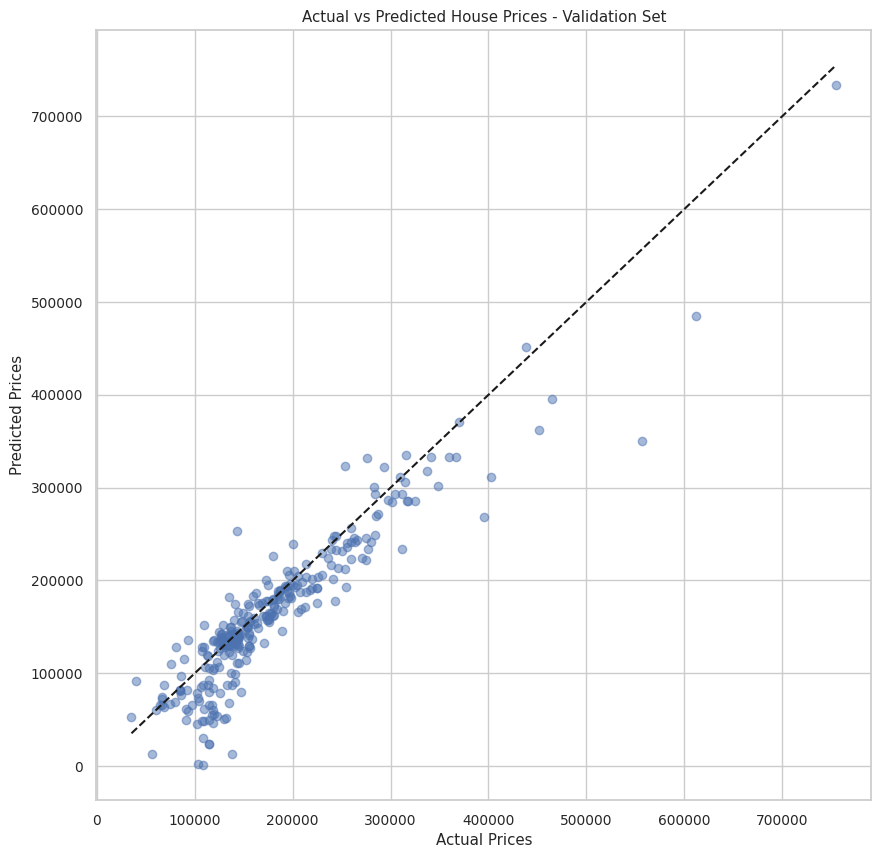

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Evaluate on validation set
test_loss, test_mae = model.evaluate(X_val_processed, y_val, verbose=0)
print(f"\nValidation MSE: {test_loss:.2f}")
print(f"Validation MAE: {test_mae:.2f}")

# Make predictions on validation set
predictions = model.predict(X_val_processed).flatten()

# Plot predictions vs actual on validation set
plt.figure(figsize=(10, 10))
plt.scatter(y_val, predictions, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices - Validation Set')
plt.show()

Now lets make a submission file

In [51]:
# Use the best model from GridSearchCV to make predictions on the test set

X_test = test_df.drop(columns=['Id'])
X_test = preprocessor.transform(X_test)

# The best_model is a pipeline that includes the preprocessor, so we can directly use it on the raw test data
predictions_test = model.predict(X_test).flatten()

# Create the submission file
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions_test
})

submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Submission file created successfully!


As I suspected, this was not the best approach and my submission left me with an MSE of 0.55510.

Now I will apply gridseatch to create a model with dropout and altering the batch size.

In [52]:
class TrainingHistory(Callback):
    def __init__(self):
        super().__init__()
        self.history = {
            'loss': [],
            'val_loss': [],
            'mae': [],
            'val_mae': []
        }

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for key in self.history.keys():
            if key in logs:
                self.history[key].append(logs[key])

In [53]:
warnings.filterwarnings("ignore", category=UserWarning)

# ========== 1. Define Model Builder ==========
def build_model(
    dropout_rate: float = 0.3,
    meta=None
):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(meta["n_features_in_"],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model


In [54]:
# class HistoryCallback(Callback):
#     def __init__(self):
#         super().__init__()
#         self.epoch_data = []

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         self.epoch_data.append({
#             'loss': logs.get('loss'),
#             'val_loss': logs.get('val_loss'),
#             'mae': logs.get('mae'),
#             'val_mae': logs.get('val_mae')
#         })

history_callback = TrainingHistory()

In [55]:


regressor = KerasRegressor(
    model=build_model,
    dropout_rate=0.3,
    epochs=200,
    batch_size=32,
    verbose=0,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        history_callback
    ],
    random_state=42,
    optimizer__learning_rate=0.001
)

param_grid = {
    'dropout_rate': [0.2, 0.3],  # No 'model__' prefix needed in scikeras
    'batch_size': [32, 64]
}


In [56]:
grid = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=1,
    error_score='raise',

)

grid.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_val))

print("Best params:", grid.best_params_)
print("Best score (negative MAE):", grid.best_score_)

best_model = grid.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ....................batch_size=32, dropout_rate=0.2; total time= 1.7min
[CV] END ....................batch_size=32, dropout_rate=0.2; total time= 1.6min
[CV] END ....................batch_size=32, dropout_rate=0.2; total time= 1.5min
[CV] END ....................batch_size=32, dropout_rate=0.3; total time= 1.4min
[CV] END ....................batch_size=32, dropout_rate=0.3; total time= 1.3min
[CV] END ....................batch_size=32, dropout_rate=0.3; total time= 1.4min
[CV] END ....................batch_size=64, dropout_rate=0.2; total time= 1.2min
[CV] END ....................batch_size=64, dropout_rate=0.2; total time= 1.2min
[CV] END ....................batch_size=64, dropout_rate=0.2; total time= 1.4min
[CV] END ....................batch_size=64, dropout_rate=0.3; total time= 1.3min
[CV] END ....................batch_size=64, dropout_rate=0.3; total time= 1.5min
[CV] END ....................batch_size=64, dropo

In [57]:
best_params = grid.best_params_
print(best_params)

# Get best dropout
best_dropout = best_params['dropout_rate']

# Rebuild model with best params
keras_model = build_model(
    dropout_rate=best_dropout,
    meta={"n_features_in_": X_train_processed.shape[1]}
)

history_callback = TrainingHistory()

keras_model.fit(
    X_train_processed,
    y_train,
    validation_data=(X_val_processed, y_val),
    batch_size=best_params['batch_size'],
    epochs=100,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        history_callback
    ],
    verbose=0
)


{'batch_size': 32, 'dropout_rate': 0.3}


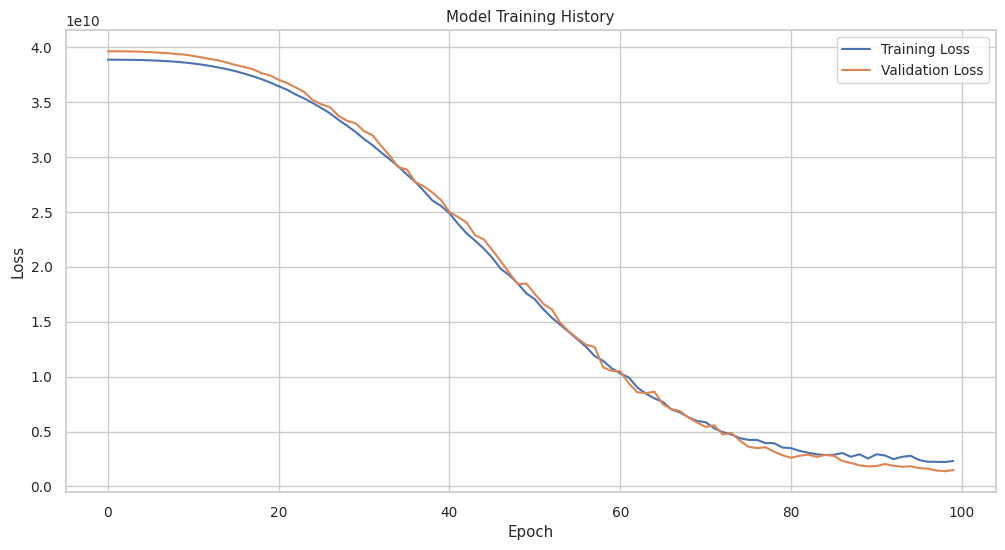


Best Parameters: {'batch_size': 32, 'dropout_rate': 0.3}
Best Validation Score (MAE): 30443.1999


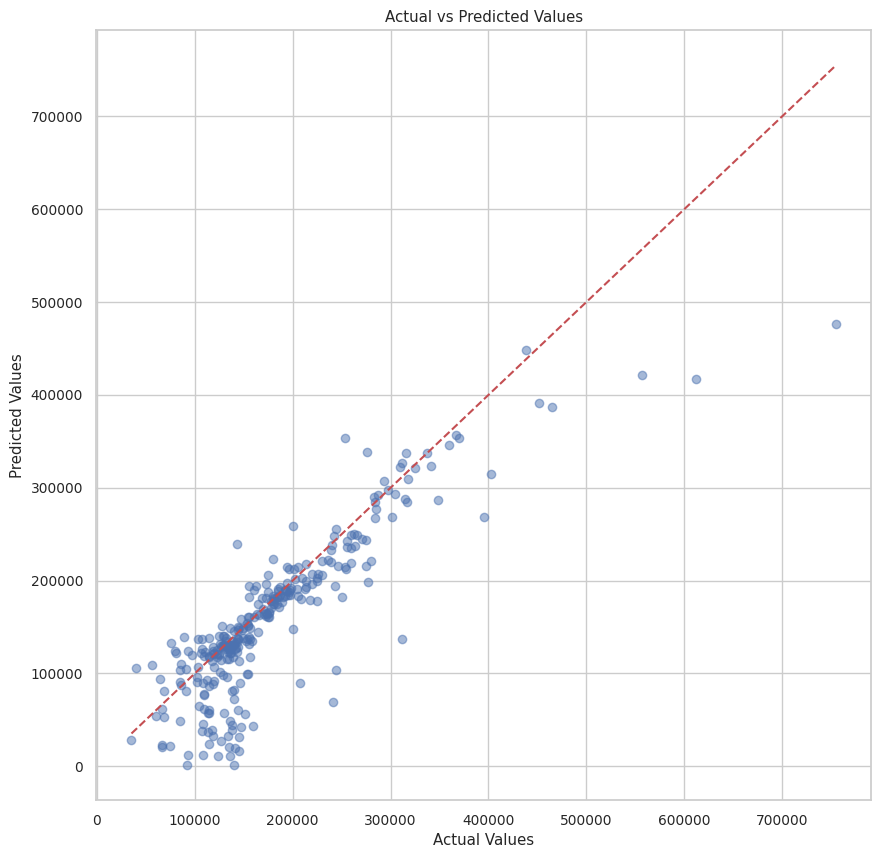

In [58]:
# 5. Plot Training History
plt.figure(figsize=(12, 6))
plt.plot(history_callback.history['loss'], label='Training Loss')
plt.plot(history_callback.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 6. Evaluation Metrics
best_model = grid.best_estimator_
print("\nBest Parameters:", grid.best_params_)
print(f"Best Validation Score (MAE): {-grid.best_score_:.4f}")

# 7. Actual vs Predicted Plot
predictions = best_model.predict(X_val_processed)
plt.figure(figsize=(10, 10))
plt.scatter(y_val, predictions, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()

In [59]:
# Use the best model from GridSearchCV to make predictions on the test set


X_test = test_df.drop(columns=['Id'])
X_test = preprocessor.transform(X_test)

# The best_model is a pipeline that includes the preprocessor, so we can directly use it on the raw test data
predictions_test_grid = best_model.predict(X_test).flatten()

# Create the submission file
submission_grid = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions_test_grid
})

submission_grid.to_csv('submission_grid.csv', index=False)

print("submission_grid file created successfully!")

submission_grid file created successfully!


## Result

My Simple multivariable regression approach yielded the best score of 0.52

Next Best was My model without dropout which yielded a score of 0.555

Finally my worst score was my most complicated model which yielded a score of 0.69

## Conclusion

The length of time it takes to run these models, the absence of a concrete improvement in predictability and the unintuitive nature of them means that I would not reccommend the use of a neural network in a regression type problem such as this.

If I was to attempt this problem again, I would look at a dimensionality reduction approach plus a simple explainable linear regression.

I could also have investigated skip connections or alternatives to adam but I think that a neural network was overkill for this problem.

Looking through the internet regression problems suited to a neural network are more complex than the one that I had.